In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("../../..")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/jaxneurorl/projects/humansf/analysis
changing to root directory
at directory: /Users/wilka/git/research/jaxneurorl


In [5]:
# !pip install google-cloud-storage
# !pip install git+https://github.com/wcarvalho/nicewebrl --no-deps
# !pip install ipywidgets
# !pip install polars
# !pip install nicegui

In [6]:
import jax
import jax.numpy as jnp
import functools
from functools import partial
import pandas as pd
import numpy as np
from pprint import pprint
import glob
from glob import glob
import matplotlib.pyplot as plt
import polars as pl
from tqdm.notebook import tqdm

from projects.humansf import data_loading
from projects.humansf import housemaze_analysis
from projects.humansf import data_loading
from projects.humansf import housemaze_trainer
from projects.humansf import housemaze_experiments
from projects.humansf import networks
from housemaze.human_dyna import mazes

from housemaze import renderer
from housemaze import utils
from housemaze.human_dyna import multitask_env as maze
from jaxneurorl import launcher
from jaxneurorl.agents import value_based_basics as vbb


from projects.humansf import download_data

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


/Users/wilka/miniforge3/envs/jaxneurorl/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:145: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


In [7]:
# data_dir = '/n/holylfs06/LABS/kempner_fellow_wcarvalho/results/jaxrl_result/housemaze_trainer'
data_dir = '/Users/wilka/git/research/results/human_dyna'

In [8]:
# experiments = [
#    'exp1_block1',
#    'exp1_block2',
#    'exp1_block3',
#    'exp1_block4',
# ]
dummy_env_params = housemaze_analysis.get_params(mazes.big_practice_maze)
dummy_rng = jax.random.PRNGKey(42)
task_runner = maze.TaskRunner(task_objects=housemaze_analysis.task_objects)
env = maze.HouseMaze(
    task_runner=task_runner,
    num_categories=200,
)
env = utils.AutoResetWrapper(env)
nenvs=25
example_timestep = env.reset(dummy_rng, dummy_env_params)

# Setup databases

For every algorithm, for every experiment, we will
1. load the algorithm
2. collect K=100 episodes for that algorithm on task objects, we can choose multiple or 1 task object. 
    we'll always use the 1st task object from the train and test sets
3. for each of these K episodes, we're going to create an entry inside a polars dataframe including (1) whether eval or not, (2) algorithm (3) experiment (4) room (5) task_idx

We'll want to options
1. if we reload this script, if possible load (a) algorithm df and (b) algorithm episodes from trajectory and don't recompute
3. option to force recomputation and overwrite data on disk


In the end, we'll have dfs for every algorithm and an episode dict which goes (alg:list). we'll use these to two subselect data for different algorithms. we'll write a small select function which takes in this merged df and this episode dict




We'll want to re-do this for users\

In [9]:
# !ls ~/git/research/results/human_dyna/model_data/*/save_data/*/*/*/analysis

In [9]:
# !rm -r ~/git/research/results/human_dyna/model_data/*/save_data/*/*/*/analysis

In [10]:
model_df_list = []
model_episodes_list = []


### Q-learning

In [11]:
exp = 'exp1'
# qlearning_dir = f'ql/save_data/ql-21/exp={exp}'
qlearning_dir = download_data.qlearning_dir
paths = f'{data_dir}/model_data/{qlearning_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='qlearning',
        make_fns=housemaze_trainer.get_qlearning_fns,
        env=env,
        example_env_params=dummy_env_params,
        nenvs=nenvs,
    )
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed)
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)
    


  0%|          | 0/10 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research

eval,algo,exp,room,task,maze_name,seed
bool,str,str,i64,i64,str,i64
false,"""qlearning""","""exp1""",0,26,"""maze6""",3
true,"""qlearning""","""exp1""",0,40,"""maze6""",3
false,"""qlearning""","""exp1""",0,26,"""maze6_flipped_offtask""",3
true,"""qlearning""","""exp1""",0,40,"""maze6_flipped_offtask""",3
false,"""qlearning""","""exp1""",0,26,"""maze3_open2""",3


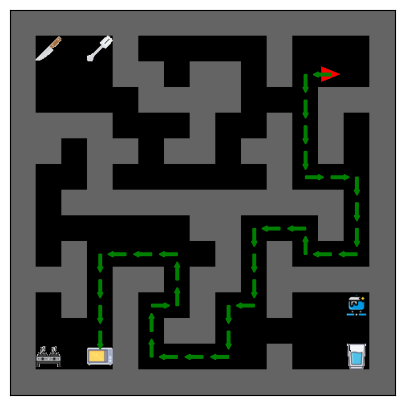

In [12]:
def first(eps): return jax.tree_map(lambda x:x[0], eps)
housemaze_analysis.render_path(first(episodes[0]))
df.head()

### Dyna-Q

In [13]:
exp = 'exp1'
# dyna_dir = f'ql/save_data/ql-21/exp={exp}'
dyna_dir = download_data.dyna_dir
paths = f'{data_dir}/model_data/{dyna_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='dynaq_shared',
        make_fns=functools.partial(housemaze_trainer.get_dynaq_fns,
            env=env,
            env_params=dummy_env_params,
            task_objects=housemaze_analysis.task_objects),
        env=env,
        example_env_params=dummy_env_params,
        nenvs=nenvs)
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed)
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)



  0%|          | 0/10 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research

eval,algo,exp,room,task,budget,maze_name
bool,str,str,i64,i64,str,str
false,"""dfs""","""exp1""",0,26,null,"""maze6"""
true,"""dfs""","""exp1""",0,40,null,"""maze6"""
false,"""dfs""","""exp1""",0,26,null,"""maze6_flipped_offtask"""
true,"""dfs""","""exp1""",0,40,null,"""maze6_flipped_offtask"""
false,"""dfs""","""exp1""",0,26,null,"""maze3_open2"""


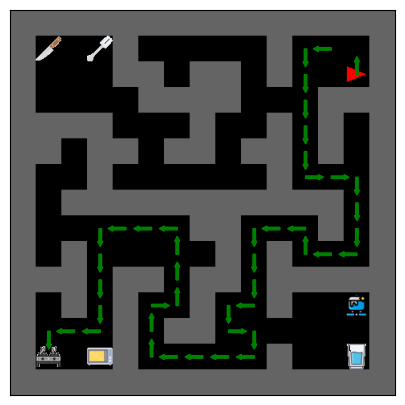

In [16]:
housemaze_analysis.render_path(first(episodes[0]))
df.head()

### BFS/DFS

In [15]:
for algorithm in ['bfs', 'dfs']:
    df, episodes = housemaze_analysis.get_search_data(
        algorithm=algorithm,
        env=env,
        exp='exp1',
        base_path=f'{data_dir}/search_algos',
        budget=None,
        overwrite=False,
        searches=10,
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


eval,algo,exp,room,task,budget,maze_name
bool,str,str,i64,i64,str,str
false,"""dfs""","""exp1""",0,26,null,"""maze6"""
true,"""dfs""","""exp1""",0,40,null,"""maze6"""
false,"""dfs""","""exp1""",0,26,null,"""maze6_flipped_offtask"""
true,"""dfs""","""exp1""",0,40,null,"""maze6_flipped_offtask"""
false,"""dfs""","""exp1""",0,26,null,"""maze3_open2"""


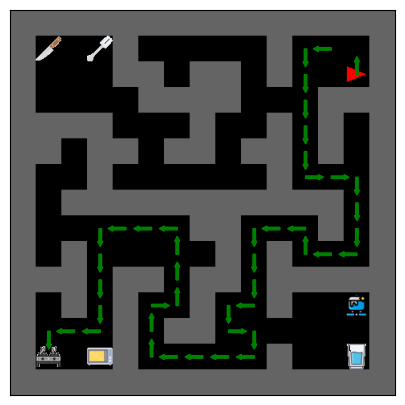

In [17]:
housemaze_analysis.render_path(first(episodes[0]))
df.head()

# put all model things together now

In [18]:
model_df = (
    pl.concat(model_df_list, how="diagonal_relaxed")
    .with_row_count(name="row_number")
    .with_columns(
        pl.col("row_number").add(1).alias("index")
    )
    .drop("row_number")
)
model_df.head()

/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_70617/2695391769.py:2: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  pl.concat(model_df_list, how="diagonal_relaxed")


eval,algo,exp,room,task,maze_name,seed,budget,index
bool,str,str,i64,i64,str,i64,str,u32
false,"""qlearning""","""exp1""",0,26,"""maze6""",6,null,1
true,"""qlearning""","""exp1""",0,40,"""maze6""",6,null,2
false,"""qlearning""","""exp1""",0,26,"""maze6_flipped_offtask""",6,null,3
true,"""qlearning""","""exp1""",0,40,"""maze6_flipped_offtask""",6,null,4
false,"""qlearning""","""exp1""",0,26,"""maze3_open2""",6,null,5


# Okay, now getting human data

In [14]:
!ls -lhtr ~/git/research/results/human_dyna/user_data/exp2*

total 728568
-rw-r--r--@ 1 wilka  staff   327K Sep 21 16:42 data_user=802309101_name=r0-exp2-obj1-v0_exp=2_debug=0.json
-rw-r--r--@ 1 wilka  staff   7.9M Sep 21 16:58 data_user=291125250_name=r0-exp2-obj1-v0_exp=2_debug=0.json
-rw-r--r--@ 1 wilka  staff   239K Sep 21 17:00 data_user=423658909_name=r0-exp2-obj1-v0_exp=2_debug=0.json
-rw-r--r--@ 1 wilka  staff   239K Sep 21 17:02 data_user=807828330_name=r0-exp2-obj1-v0_exp=2_debug=0.json
-rw-r--r--@ 1 wilka  staff    25M Sep 22 15:27 data_user=4080164882_name=r0-exp2-obj1-v0_exp=2_debug=0.json
-rw-r--r--@ 1 wilka  staff   457K Sep 22 15:58 data_user=1280649067_name=r0-exp2-obj1-v0_exp=2_debug=0.json
-rw-r--r--@ 1 wilka  staff    39M Sep 22 16:44 data_user=4280931996_name=r0-exp2-obj1-v0_exp=2_debug=0.json
-rw-r--r--@ 1 wilka  staff    71M Sep 22 16:48 data_user=1554047271_name=r0-exp2-obj0-v0_exp=2_debug=0.json
-rw-r--r--@ 1 wilka  staff    23M Sep 22 16:48 data_user=3894852775_name=r0-exp2-obj1-v0_exp=2_debug=0.json
-rw-r--r--@ 1 wilka

In [12]:
# !rm ~/git/research/results/human_dyna/user_data/*3714894224_name* ~/git/research/results/human_dyna/user_data/*2631242498_name*

In [18]:
data_dir = '/Users/wilka/git/research/results/human_dyna/'
files = f'{data_dir}/user_data/exp2/*obj1*.json'
user_base_path = f'{data_dir}/user_data'
files = glob(files)
files

['/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=2801744689_name=r0-exp2-obj1-v0_exp=2_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=807828330_name=r0-exp2-obj1-v0_exp=2_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=802309101_name=r0-exp2-obj1-v0_exp=2_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=291125250_name=r0-exp2-obj1-v0_exp=2_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=3292765477_name=r0-exp2-obj1-v0_exp=2_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=1968184994_name=r0-exp2-obj1-v0_exp=2_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=3894852775_name=r0-exp2-obj1-v0_exp=2_debug=0.json',
 '/Users/wilka/git/research/results/human_dyna//user_data/exp2/data_user=4080164882_name=r0-exp2-obj1-v0_exp=2_debug=0.js

In [46]:
import json
for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
        finished = data[-1].get("finished", False)
        if finished:
            print(os.path.basename(file), ":", data[-1]['feedback'])

data_user=2801744689_name=r0-exp2-obj1-v0_exp=2_debug=0.json : 
data_user=3292765477_name=r0-exp2-obj1-v0_exp=2_debug=0.json : It was easy to understand.
data_user=3894852775_name=r0-exp2-obj1-v0_exp=2_debug=0.json : All went well.
data_user=4080164882_name=r0-exp2-obj1-v0_exp=2_debug=0.json : All good mate!
data_user=4280931996_name=r0-exp2-obj1-v0_exp=2_debug=0.json : 


In [33]:
user_df, user_data = data_loading.make_all_episode_data(
    files=files,
    example_timestep=example_timestep,
    base_path=user_base_path,
    overwrite=False,
)

No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 31 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 28 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 28 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 29 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 30 data points


Processing episodes:  70%|███████   | 38/54 [04:57<02:31,  9.50s/it]]

No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl


Processing episodes: 100%|██████████| 171/171 [13:59<00:00,  4.91s/it]


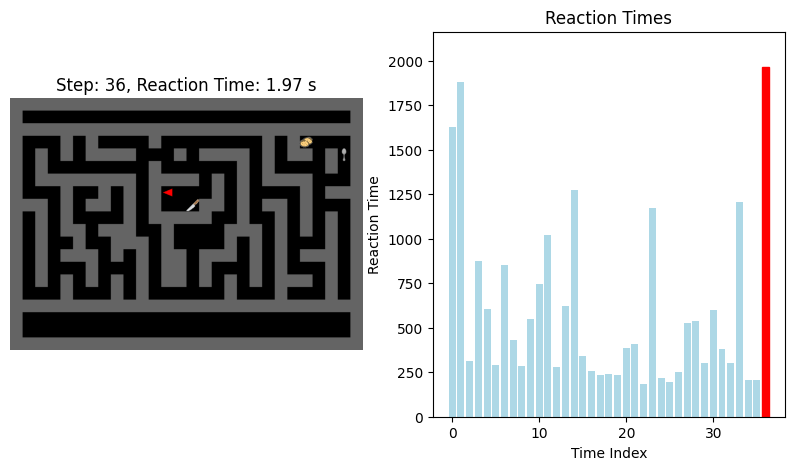

In [36]:
housemaze_analysis.create_episode_reaction_times_video(user_data[-2])
# housemaze_analysis.render_path(user_data[0])

In [31]:
user_df.head()

index,stage,block,manipulation,episode_idx,eval,user_episode_idx,task,room,user_id,age,sex
u32,str,str,i64,i64,bool,i64,i64,i64,i64,i64,str
1,null,"""reusing longer of two paths wh…",3,1,false,0,43,1,4026679196,39,"""Male"""
2,null,"""reusing longer of two paths wh…",3,2,false,1,43,1,4026679196,39,"""Male"""
3,null,"""reusing longer of two paths wh…",3,3,false,2,43,1,4026679196,39,"""Male"""
4,null,"""reusing longer of two paths wh…",3,4,false,3,43,1,4026679196,39,"""Male"""
5,null,"""reusing longer of two paths wh…",3,5,false,4,3,1,4026679196,39,"""Male"""


# Now compute metrics for each manipulation

In [47]:
def get_user_samples(**kwargs):
    eval_df = user_df.filter(**kwargs)
    idxs = np.array(eval_df['index'])-1
    return idxs

def plot_user_sample(idx=0, ax=None, **kwargs):
    eval_df = user_df.filter(**kwargs)
    idxs = np.array(eval_df['index'])-1
    print(idxs[idx])
    housemaze_analysis.render_path(user_data[idxs[idx]], ax=ax)

def plot_users_sample(user_settings):
    num_users = min(len(user_df['user_id'].unique()), 4)
    fig, axes = plt.subplots(1, num_users, figsize=(3*num_users, 3), squeeze=False)
    axes = axes.flatten()
    
    # Iterate through unique models and plot each one
    users = list(user_df['user_id'].unique())[:num_users]
    for i, user in enumerate(users):
        plot_user_sample(ax=axes[i], user_id=user, **user_settings)
        axes[i].set_title(user)
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

def get_human_data(user_df, user_data, fn, **kwargs):
    eval_df = user_df.filter(**kwargs)
    idxs = np.array(eval_df['index'])-1
    array = []
    for idx in idxs:
        val = fn(user_data[idx])
        array.append(val)

    return array

get_human_data = partial(housemaze_analysis.get_human_data,
                         user_df=user_df, user_data=user_data)

No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


In [33]:
def plot_model_sample(idx=0, ax=None, **kwargs):
    eval_df = model_df.filter(**kwargs)
    idxs = np.array(eval_df['index'])-1
    print(idxs[idx])
    housemaze_analysis.render_path(first(model_episodes_list[idxs[idx]]), ax=ax)


def plot_models_sample(model_settings):
    num_models = len(model_df['algo'].unique())
    fig, axes = plt.subplots(1, num_models, figsize=(3*num_models, 3), squeeze=False)
    axes = axes.flatten()
    
    # Iterate through unique models and plot each one
    for i, model in enumerate(model_df['algo'].unique()):
        plot_model_sample(ax=axes[i], algo=model, **model_settings)
        axes[i].set_title(model)
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

get_model_data = partial(housemaze_analysis.get_model_data,
                         model_df=model_df, model_data=model_episodes_list)


In [48]:
# model_df['algo'].unique()

In [49]:
# model_df['maze_name'].unique()

---
## Manipulation 1: shortcut is introduced

Here, a short is introduced at evaluation time and we want to see if users follow the short-cut or if they use the old path

How will we compute for the user?
1. for each user, get the eval episode data
2. look for point on map which corresponds to "shortcut"
3. compute binary if the episode crossed through there

50
225
281
316


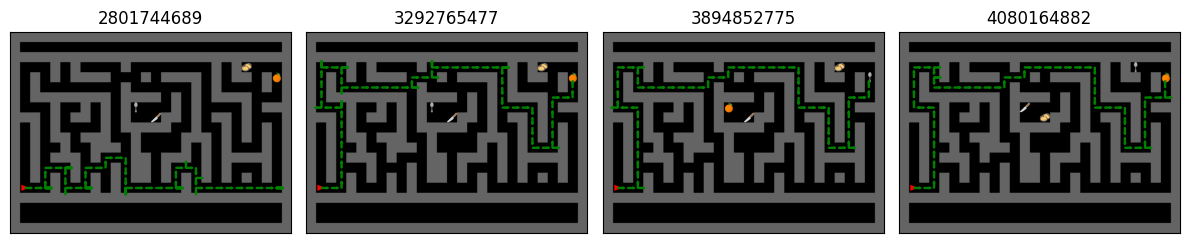

In [50]:
# plot_user_sample(manipulation=1, eval=True)
plot_users_sample(dict(manipulation=1, eval=True))
plt.show()

In [51]:
# m1_model_settings = dict(maze_name='maze3_open2', eval=True)
# plot_models_sample(m1_model_settings)


{'human': [Array(1., dtype=float32),
           Array(1., dtype=float32),
           Array(1., dtype=float32),
           Array(1., dtype=float32)]}


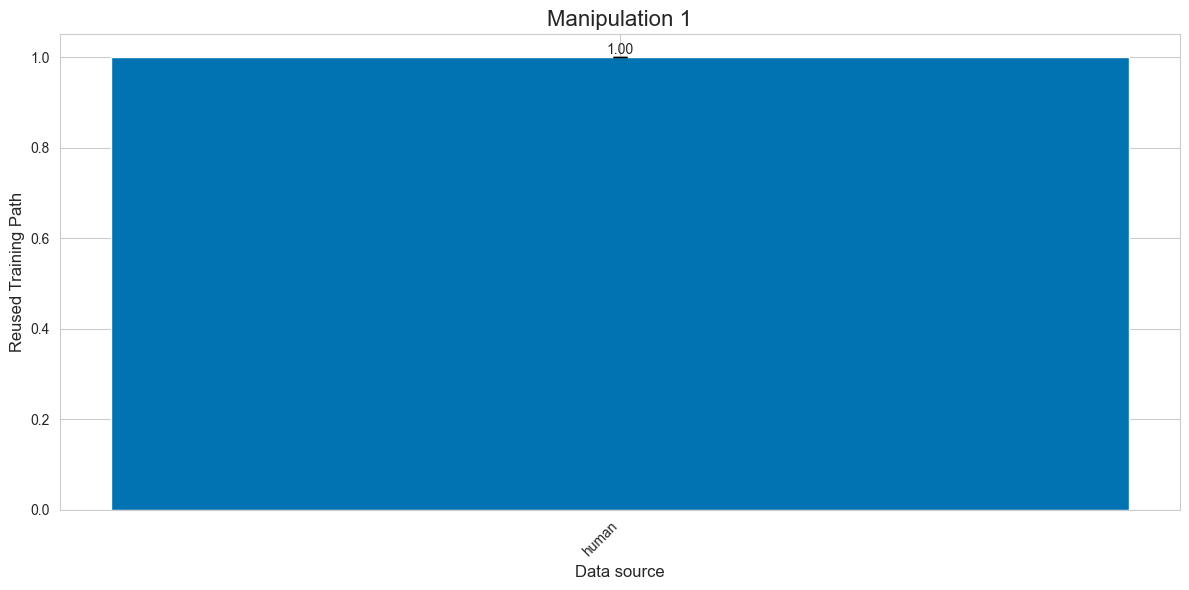

In [64]:
# get user data
def went_to_junction(episode_data, junction = (0, 11)):
    positions = episode_data.positions
    match = np.array(junction) == positions
    match = (match).sum(-1) == 2 # both x and y matches
    return match.any().astype(jnp.float32)  # if any matched

fn = functools.partial(went_to_junction, junction=(2, 14))
filter_fn = lambda e: housemaze_analysis.success(e) < 1
reused_path_data = dict(
    # vector of people
    human=get_human_data(fn=fn, filter_fn=filter_fn, manipulation=1, eval=True),
    # # vector of seeds
    # qlearning=get_model_data(fn=fn, algo="qlearning", **m1_model_settings),
    # dyna=get_model_data(fn=fn, algo="dynaq_shared", **m1_model_settings),
    # bfs=get_model_data(fn=fn, algo='bfs', **m1_model_settings),
    # dfs=get_model_data(fn=fn, algo='dfs', **m1_model_settings),
)

pprint(reused_path_data)
housemaze_analysis.bar_plot_results(reused_path_data, title='Manipulation 1', ylabel='Reused Training Path')

In [55]:
success_data = dict(
    # vector of people
    human=get_human_data(fn=housemaze_analysis.success, manipulation=1, eval=True),
    # # vector of seeds
    # qlearning=get_model_data(fn=housemaze_analysis.success, algo="qlearning", **m1_model_settings),
    # dyna=get_model_data(fn=housemaze_analysis.success,algo="dynaq_shared",  **m1_model_settings),
    # bfs=get_model_data(fn=housemaze_analysis.success, algo='bfs', **m1_model_settings),
    # dfs=get_model_data(fn=housemaze_analysis.success, algo='dfs', **m1_model_settings),
)
success_data

{'human': [Array(0., dtype=float32),
  Array(1., dtype=float32),
  Array(1., dtype=float32),
  Array(1., dtype=float32),
  Array(1., dtype=float32)]}

---
## Manipulation 3: reusing longer of two paths which matches training path

Here there are 2 paths. do people take the short or long one?


264


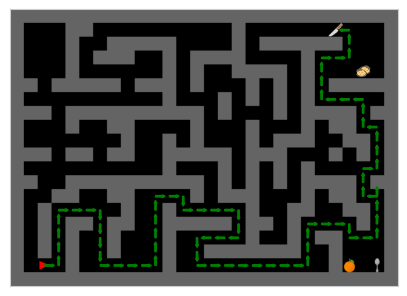

In [68]:
# plot_user_sample(manipulation=3, eval=True)
plot_user_sample(idx=2, manipulation=3, eval=True)

In [62]:
# plot_user_sample(idx=5, manipulation=3, eval=False)

In [63]:
# m3_model_settings = dict(maze_name='maze5', eval=True)
# plot_models_sample(m3_model_settings)
# # housemaze_analysis.render_path(first(model_episodes_list[170]))


In [40]:
# def fn(e):
#     new_path = went_to_position(e.positions, (0,3))
#     return float(new_path)

# new_path_data = dict(
#     # vector of people
#     human=get_human_data(fn=fn, manipulation=3, eval=True),
#     # vector of seeds
#     qlearning=get_model_data(fn=fn, algo="qlearning", **m3_model_settings),
#     dyna=get_model_data(fn=fn, algo="dynaq_shared", **m3_model_settings),
#     bfs=get_model_data(fn=fn, algo='bfs', **m3_model_settings),
#     dfs=get_model_data(fn=fn, algo='dfs', **m3_model_settings),

# )

# new_path_data

{'human': [1.0, 1.0],
 'qlearning': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'dyna': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'bfs': array([0.], dtype=float32),
 'dfs': array([0.], dtype=float32)}

{'human': [Array(1., dtype=float32),
           Array(1., dtype=float32),
           Array(1., dtype=float32),
           Array(1., dtype=float32)]}


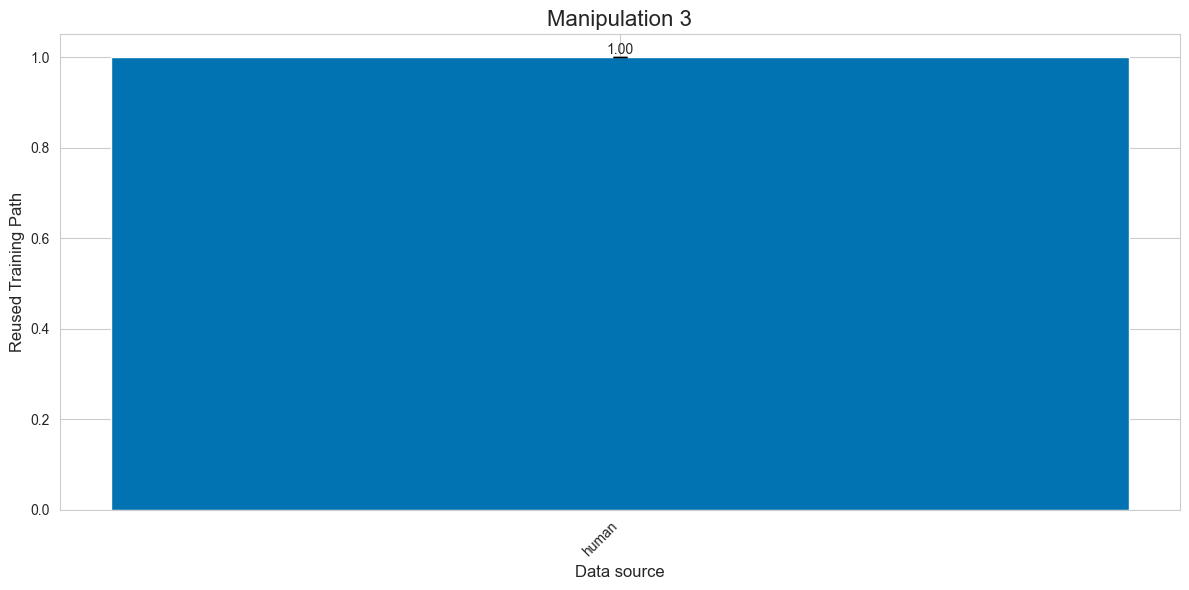

In [69]:
def went_to_junction(episode_data, junction = (17, 13)):
    positions = episode_data.positions
    match = np.array(junction) == positions
    match = (match).sum(-1) == 2 # both x and y matches
    return match.any().astype(jnp.float32)  # if any matched

fn = functools.partial(went_to_junction, junction=(2, 14))
filter_fn = lambda e: housemaze_analysis.success(e) < 1
reused_path_data = dict(
    # vector of people
    human=get_human_data(fn=fn, filter_fn=filter_fn, manipulation=1, eval=True),
    # # vector of seeds
    # qlearning=get_model_data(fn=fn, algo="qlearning", **m1_model_settings),
    # dyna=get_model_data(fn=fn, algo="dynaq_shared", **m1_model_settings),
    # bfs=get_model_data(fn=fn, algo='bfs', **m1_model_settings),
    # dfs=get_model_data(fn=fn, algo='dfs', **m1_model_settings),
)

pprint(reused_path_data)
housemaze_analysis.bar_plot_results(reused_path_data, title='Manipulation 3', ylabel='Reused Training Path')

In [41]:
success_data = dict(
    # vector of people
    human=get_human_data(fn=housemaze_analysis.success, manipulation=3, eval=True),
    # vector of seeds
    qlearning=get_model_data(fn=housemaze_analysis.success, algo="qlearning", **m3_model_settings),
    dyna=get_model_data(fn=housemaze_analysis.success,algo="dynaq_shared",  **m3_model_settings),
    bfs=get_model_data(fn=housemaze_analysis.success, algo='bfs', **m3_model_settings),
    dfs=get_model_data(fn=housemaze_analysis.success, algo='dfs', **m3_model_settings),
)
success_data

{'human': [Array(1., dtype=float32), Array(1., dtype=float32)],
 'qlearning': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'dyna': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 'bfs': array([1.], dtype=float32),
 'dfs': array([0.6], dtype=float32)}

## Manipulation 2: faster when on-path but further than off-path but closer
In both tests, a shortcut is introduced. In the first, the agent is tested on the same path it trained on. In the second, the agent is tested on a different path.reusing longer of two paths which matches training path

Here there are 2 paths. do people take the short or long one?


what do I want to do?
1. I want to get the user data for each participant for the episode
2. I want to get a vector of the reaction times. for now, just plot that as a histogram. 4 histograms alone may be informative....

new location, on-path
169
244
298
333


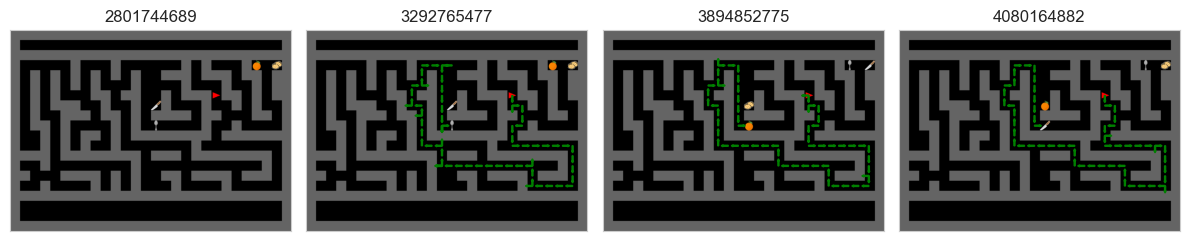

new location, off-path
170
245
299
334


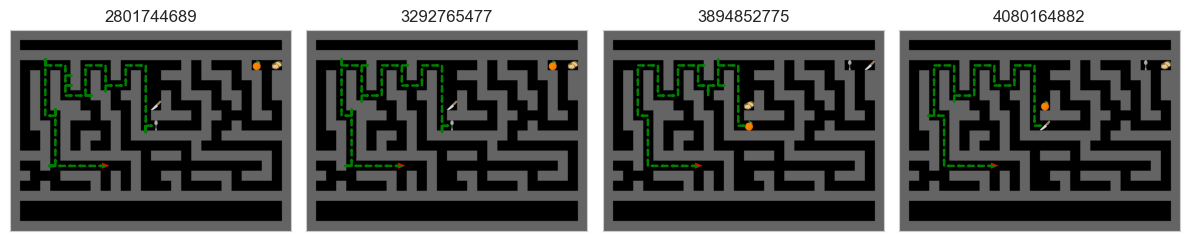

In [70]:
sub_df = user_df.filter(manipulation=2, eval=True)
for stage in sub_df['stage'].unique():
    print(stage)
    plot_users_sample(dict(manipulation=2, eval=True, stage=stage))
    plt.show()

Stage: new location, off-path


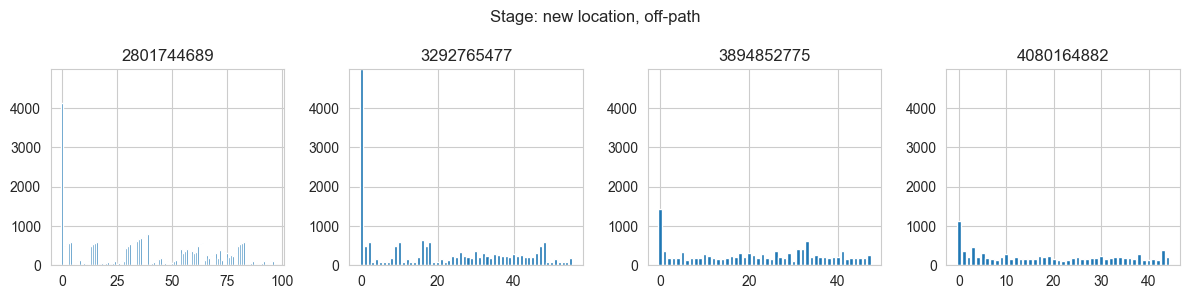

Stage: new location, on-path


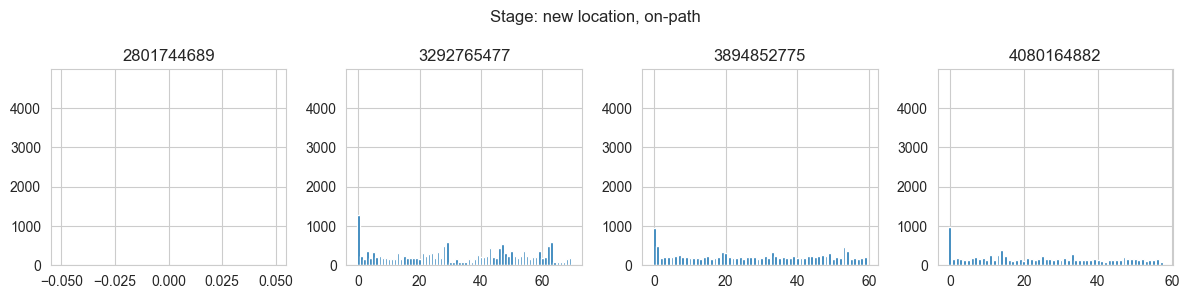

In [106]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reaction_hists(user_df, user_data, user_settings, y_max, use_final=False):
    num_users = min(len(user_df['user_id'].unique()), 4)
    fig, axes = plt.subplots(1, num_users, figsize=(3*num_users, 3), squeeze=False)
    axes = axes.flatten()
    
    users = list(user_df['user_id'].unique())[:num_users]
    
    for i, user in enumerate(users):
        eval_df = user_df.filter(user_id=user, **user_settings)
        idxs = np.array(eval_df['index'])-1
        assert len(idxs) == 1, f'{len(idxs)} options?'
        episode_data = user_data[idxs[0]]
        if use_final: reaction_times = episode_data.reaction_times
        else: reaction_times = episode_data.reaction_times[:-1]

        
        axes[i].bar(np.arange(len(reaction_times)), reaction_times)
        axes[i].set_title(user)
        axes[i].set_ylim(0, y_max)  # Set the same y-axis limit for all plots
    
    plt.suptitle(f"Stage: {user_settings['stage']}")
    plt.tight_layout()
    plt.show()

def plot_all_stages(user_df, user_data, use_final=False, filter_fn=None, **kwargs):
    sub_df = user_df.filter(**kwargs)
    stages = ["new location, off-path", "new location, on-path"]
    
    # First, find the global maximum reaction time across all stages
    all_reaction_times = []
    for stage in stages:
        stage_df = sub_df.filter(stage=stage)
        for user in stage_df['user_id'].unique():
            eval_df = stage_df.filter(user_id=user)
            idxs = np.array(eval_df['index'])-1
            episode_data = user_data[idxs[0]]
            if filter_fn is not None:
                if filter_fn(episode_data): continue
            if use_final: rts = episode_data.reaction_times
            else: rts = episode_data.reaction_times[:-1]
            all_reaction_times.extend(rts)
    
    global_y_max = max(all_reaction_times)
    
    # Now plot for each stage
    for stage in stages:
        print(f"Stage: {stage}")
        plot_reaction_hists(user_df, user_data, 
                            use_final=use_final,
                            user_settings=dict(**kwargs, stage=stage),
                            y_max=global_y_max)

# Usage
filter_fn = lambda e: housemaze_analysis.success(e) < 1
plot_all_stages(user_df, user_data, filter_fn=filter_fn, use_final=False, manipulation=2, eval=True)

/Users/wilka/miniforge3/envs/jaxneurorl/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:145: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
{2801744689: {'new location, off-path': Array(4398.75, dtype=float32)},
 3292765477: {'new location, off-path': Array(5229.709, dtype=float32),
              'new location, on-path': Array(1523.3914, dtype=float32)},
 3894852775: {'new location, off-path': Array(1669.6171, dtype=float32),
              'new location, on-path': Array(1169.678, dtype=float32)},
 4080164882: {'new location, off-path': Array(1318.25, dtype=float32),
              'new location, on-path': Array(1138.1228, dtype=float32)},
 4280931996: {}}


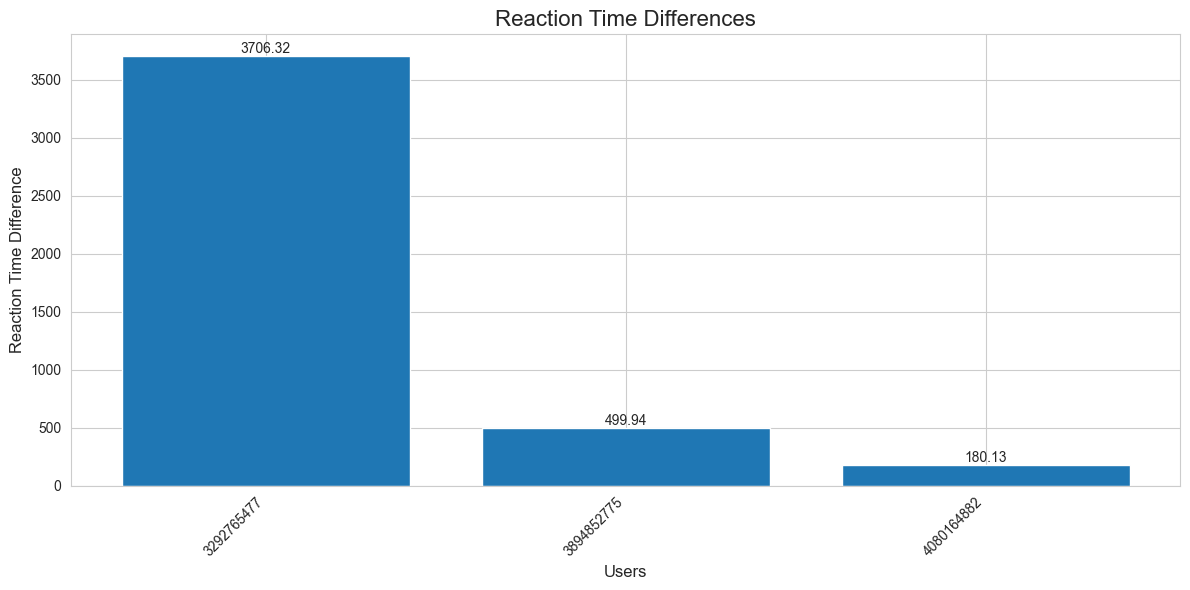

In [107]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reaction_time_differences(user_df, user_data, use_final=False, filter_fn=None, rt_fn=np.sum, **kwargs):
    sub_df = user_df.filter(**kwargs)
    stages = ["new location, off-path", "new location, on-path"]
    
    assert len(stages) == 2, "This function assumes there are exactly 2 stages"
    
    # Dictionary to store reaction times for each user in each stage
    user_reaction_times = {}
    
    for stage in stages:
        stage_df = sub_df.filter(stage=stage)
        for user in stage_df['user_id'].unique():
            if user not in user_reaction_times:
                user_reaction_times[user] = {}
            
            eval_df = stage_df.filter(user_id=user)
            idxs = np.array(eval_df['index']) - 1
            episode_data = user_data[idxs[0]]
            
            if filter_fn is not None:
                if filter_fn(episode_data):
                    continue
            
            if use_final:
                rts = episode_data.reaction_times
            else:
                rts = episode_data.reaction_times[:-1]
            
            user_reaction_times[user][stage] = rt_fn(rts)
    pprint(user_reaction_times)
    # Calculate differences and prepare data for plotting
    users = []
    differences = []
    
    for user, stages_data in user_reaction_times.items():
        if len(stages_data) == 2:  # Ensure user has data for both stages
            users.append(user)
            diff = stages_data[stages[0]] - stages_data[stages[1]]
            differences.append(diff)
        # else:
        #     print("failed?")

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar([str(u) for u in users], differences)
    
    # Customize the plot
    plt.title(f"Reaction Time Differences", fontsize=16)
    plt.xlabel("Users", fontsize=12)
    plt.ylabel("Reaction Time Difference", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Add a horizontal line at y=0
    # plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom' if height > 0 else 'top')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()



# Usage
filter_fn = lambda e: housemaze_analysis.success(e) < 1

def rt_fn(rts):
    first = rts[0]
    return first + rts[1:].mean()
plot_reaction_time_differences(user_df, user_data, filter_fn=filter_fn, rt_fn=rt_fn, use_final=False, manipulation=2, eval=True)

{2801744689: {'new location, off-path': Array(4130., dtype=float32)},
 3292765477: {'new location, off-path': Array(4989., dtype=float32),
              'new location, on-path': Array(1290., dtype=float32)},
 3894852775: {'new location, off-path': Array(1429., dtype=float32),
              'new location, on-path': Array(946., dtype=float32)},
 4080164882: {'new location, off-path': Array(1117., dtype=float32),
              'new location, on-path': Array(977., dtype=float32)},
 4280931996: {}}


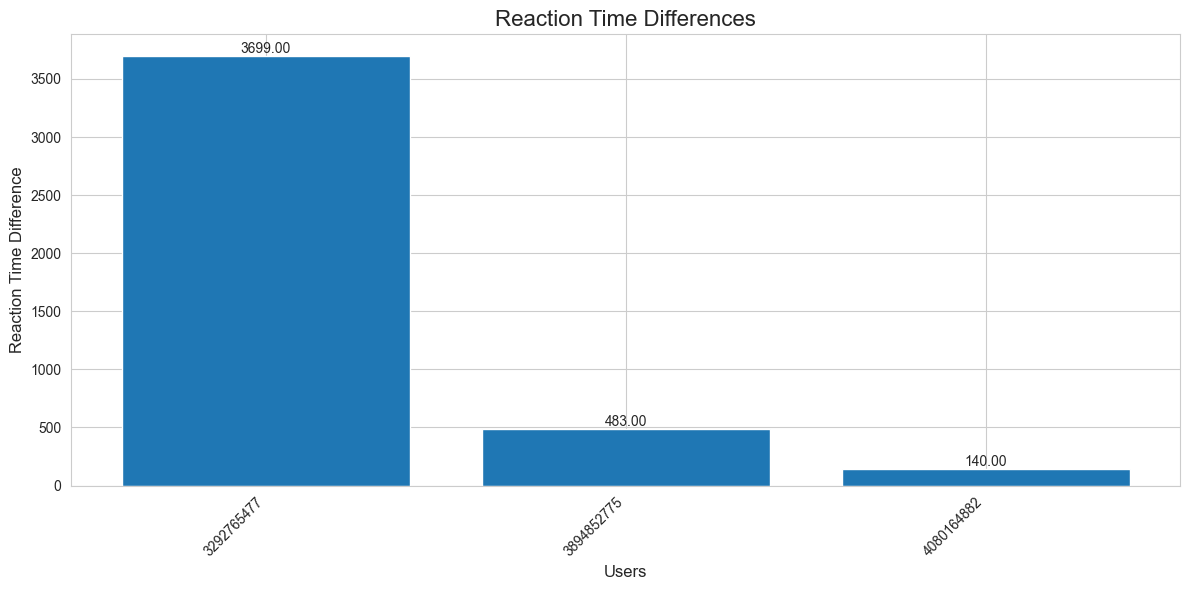

In [104]:
def rt_fn(rts):
    return rts[0]
plot_reaction_time_differences(user_df, user_data, filter_fn=filter_fn, rt_fn=rt_fn, use_final=False, manipulation=2, eval=True)

{2801744689: {'new location, off-path': Array(268.75, dtype=float32)},
 3292765477: {'new location, off-path': Array(240.70908, dtype=float32),
              'new location, on-path': Array(233.39131, dtype=float32)},
 3894852775: {'new location, off-path': Array(240.61702, dtype=float32),
              'new location, on-path': Array(223.67796, dtype=float32)},
 4080164882: {'new location, off-path': Array(201.25, dtype=float32),
              'new location, on-path': Array(161.1228, dtype=float32)},
 4280931996: {}}


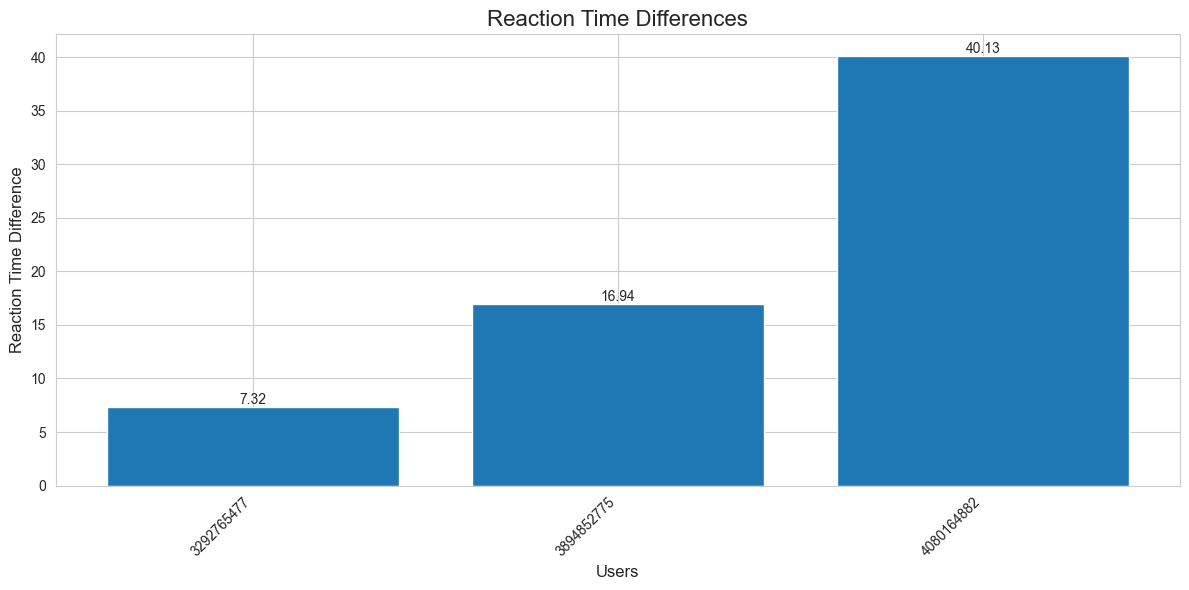

In [110]:
def rt_fn(rts):
    return rts[1:].mean()
plot_reaction_time_differences(user_df, user_data, filter_fn=filter_fn, rt_fn=rt_fn, use_final=False, manipulation=2, eval=True)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (0,).

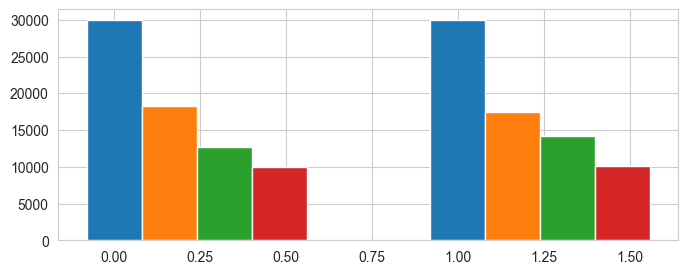

In [84]:
def plot_reaction_times_by_stage(user_df, user_data, user_settings, filter_fn=None):
    # Filter the dataframe based on user settings
    sub_df = user_df.filter(**user_settings)
    
    # Get unique stages and users
    stages = sub_df['stage'].unique()
    users = sub_df['user_id'].unique()
    
    # Prepare data for plotting
    data = []
    valid_users = set()
    for user in users:
        user_totals = []
        for stage in stages:
            eval_df = sub_df.filter(user_id=user, stage=stage)

            idx = np.array(eval_df['index'])[0] - 1
            episode_data = user_data[idx]
            if filter_fn is not None:
                if filter_fn(episode_data): continue
            reaction_times_sum = sum(episode_data.reaction_times[:-1])
            user_totals.append(reaction_times_sum)
        valid_users.add(user)

        data.append(user_totals)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 3))

    users = [u for u in users if u in valid_users]
    bar_width = 0.8 / len(users)
    index = np.arange(len(stages))
    
    for i, (user, user_data) in enumerate(zip(users, data)):
        ax.bar(index + i * bar_width, user_data, bar_width, label=f'User {user}')
    
    ax.set_xlabel('Stage')
    # ax.set_ylabel('Total Episode Time')
    ax.set_title('Total Episode Time')
    ax.set_xticks(index + bar_width * (len(users) - 1) / 2)
    ax.set_xticklabels(stages)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Usage
filter_fn = lambda e: housemaze_analysis.success(e) < 1
user_settings = dict(manipulation=2, eval=True)
plot_reaction_times_by_stage(user_df, user_data, user_settings, filter_fn=filter_fn)
